# Non-Deterministic case: DeePC vs. SPC

Comparing open-loop predictions.

This notebook is used to create the results for **Figure 2** in our paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io as sio
from casadi import *
from casadi.tools import *
import time
import itertools

In [2]:
# Random seed:
np.random.seed(1234)

In [3]:
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['axes.unicode_minus'] = 'true'
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelpad'] = 6

##  System description


We  now introduce the following linear system subject to zero-mean Gaussian noise $w_k\sim \mathcal{N}(0,\sigma_w^2 I)$:

\begin{align}
x_{k+1} &= Ax_k + Bu_k\\
y_k &= Cx_k+Du_k+w_k,
\end{align}

with $x \in \mathbb{R}^n$ (states), $u\in \mathbb{R}^m$ (inputs), $y\in \mathbb{R}^p$ (measurements) and system matrices $A \in \mathbb{R}^{n\times n}$, $B \in \mathbb{R}^{n\times m}$, $C \in \mathbb{R}^{p\times n}$ and $D \in \mathbb{R}^{p\times m}$.

The investigated system, displayed below, is a triple-mass-spring system (rotating discs) with two stepper motors ($m=2$) attached to the outermost discs via additional springs. These disc angles are the measured output of the system ($p=3$). The system has a total of $n=8$ states.

<img src="sources/triple_mass_spring.pdf" width=40%/>

To simulate the system, we created a very simple helper class, that keeps the current state and stores the past sequences of inputs, states and outputs.

We import the system class with:

In [4]:
import sys
# Add subfolder sources to path.
sys.path.append('./sources')
# Import class 'System' from file System.py
from System import System, random_u

In contrast to our notebook ``res_01_woNoise.ipynb`` we also import here the helper function ``random_u`` to stimulate the system with an PRBS-like input.

Import system matrices, $A,B,C,D$ and create instance of ``System``:

In [5]:
sys_dc = sio.loadmat('./sources/sys_dc.mat')
A = sys_dc['A_dc']
B = sys_dc['B_dc']
C = sys_dc['C']
D = sys_dc['D']

sys = System(A,B,C,D)

# DeePC vs. SPC

## Data collection

Both methods require a measured system response for persistantly exciting input data, depending on the parameters:
$T_{\text{ini}}$ and $N$.
The total number of measured sequences depends on these parameters and must exceed the thresholds given by Assumption 1, 2 and 3 in the paper. 

We first set the fixed parameters. **Note that we also set $\sigma_w$, the standard deviation of $w$**.

In [6]:
T_ini = 4
N = 40

L = T_ini + N

n_u = sys.n_u
n_y = sys.n_y

sig_w = 1e-2

Create matrices $U_L$ and $Y_L$ according to (2) in the paper. Note that we construct the data matrices which are neither Hankel nor Page matrices. Instead we "measure" independent sequences each with **random initial state**.

In contrast to our notebook ``res_01_woNoise`` we define here a function to obtain these matrices in dependence of the parameter ``T`` (number of sequences) and ``sig_w``.

In [7]:
def get_data_matrices(T, sig_w):
    U_L = []
    Y_L = []
    
    sys = System(A,B,C,D)

    u0 = np.zeros((2,1))

    for k in range(T):
        x0 = np.random.randn(8,1)
        sys.reset(x0)


        for k in range(L):
            u0 = random_u(u0)
            sys.make_step(u0)

        U_L.append(sys.u.reshape(-1,1))
        Y_L.append(sys.y.reshape(-1,1))

    U_L = np.concatenate(U_L,axis=1)
    Y_L = np.concatenate(Y_L,axis=1)

    # Add noise to Data:
    Y_L = Y_L+np.random.randn(*Y_L.shape)*sig_w

    assert np.linalg.matrix_rank(U_L) == U_L.shape[0], "not persistantly exciting."
    
    return U_L, Y_L

## SPC

We now define functions that return the configured optimal control problems for DeePC and SPC based on the multi-step prediction model.

These functions depend on $U_L$ and $Y_L$.

The optimization problem for SPC is:

\begin{align}
    \min_{u_N,y_N, \sigma_{y}, \sigma_{u}}\quad &\sum_{k=1}^N \left(\|y_k\|^2_{Q}+\|u_k\|^2_{R}\right)
    +\lambda_{\sigma_y}\|\sigma_{y}\|_2^2 +\lambda_{\sigma_u}\|\sigma_{u}\|_2^2\\
    \text{s.t.}\quad &
    y_N = 
    \tilde P^*
    \left(
    \begin{bmatrix}
        y_{T_{\text{ini}}}\\
        u_{T_{\text{ini}}}\\
        u_{N},
    \end{bmatrix}+
    \begin{bmatrix}
        \sigma_y\\
        \sigma_u\\
        0,
    \end{bmatrix}
    \right)
    \\
    &u_k \in \mathbb{U},\ \forall k\in \{1,\dots,N\},	\\
    &y_k \in \mathbb{Y},\ \forall k\in \{1,\dots,N\}.	\\
\end{align}

In [8]:
def setup_SPC(U_L, Y_L):
    # Sys ID:
    U_Tini, U_N = np.split(U_L, [n_u*T_ini],axis=0)
    Y_Tini, Y_N = np.split(Y_L, [n_y*T_ini],axis=0)
    
    M = np.concatenate((Y_Tini, U_Tini, U_N))

    P = Y_N@np.linalg.pinv(M)
    
    # Create optimization variables:
    opt_x = struct_symMX([
        entry('y_N', shape=(n_y), repeat=N),
        entry('u_N', shape=(n_u), repeat=N),
        entry('sig_y', shape=(n_y), repeat=T_ini),
        entry('sig_u', shape=(n_u), repeat=T_ini)
    ])

    # Create parameters of the optimization problem
    opt_p = struct_symMX([
        entry('u_Tini', shape=(n_u), repeat=T_ini),
        entry('y_Tini', shape=(n_y), repeat=T_ini),
    ])

    # Create numerical instances of the structures (holding all zeros as entries)
    opt_x_num = opt_x(0)
    opt_p_num = opt_p(0)
    
    # Create the objective:
    obj = 0
    for k in range(N):
        obj += sum1(opt_x['y_N',k]**2)+0.1*sum1(opt_x['u_N', k]**2)
        
    for k in range(T_ini):
        obj += 1e4*sum1(opt_x['sig_u',k]**2)+1e4*sum1(opt_x['sig_y',k]**2)


    # Create the constraints:
    b = vertcat(*opt_p['y_Tini'], *opt_p['u_Tini'], np.zeros((N*n_u,1)))
    v = vertcat(*opt_x['sig_y'], *opt_x['sig_u'], *opt_x['u_N'])
    y_N = vertcat(*opt_x['y_N'])
    cons = P@(b+v)-y_N


    # Create lower and upper bound structures and set all values to plus/minus infinity.
    lbx = opt_x(-np.inf)
    ubx = opt_x(np.inf)

    # Set only bounds on u_N
    lbx['u_N'] = -0.7
    ubx['u_N'] = 0.7


    # Create Optim
    nlp = {'x':opt_x, 'f':obj, 'g':cons, 'p':opt_p}
    S_spc = nlpsol('S', 'ipopt', nlp)
    
    return S_spc, opt_x_num, opt_p_num, lbx, ubx

## DeePC problem

For the non-deterministic case we implement the adapted DeePC problem:

\begin{aligned}
	\min_{
		g,u_N, y_N, \sigma_{y}, \sigma_{u}
	}\quad &
	\sum_{k=1}^N \left(\|y_k\|^2_{Q}+\|u_k\|^2_{R}\right)
	+\lambda_g \|g\|_2^2+\lambda_{\sigma_y}\|\sigma_{y}\|_2^2 +\lambda_{\sigma_u}\|\sigma_{u}\|_2^2\\
	\text{s.t.}\quad & 
	\left[\begin{array}{c}
	\tilde Y_{T_\text{ini}}\\
	U_{T_\text{ini}}\\
	U_{N}\\
	\tilde Y_N
	\end{array}\right] g 
	= 
	\left[\begin{array}{c}
	y_{T_\text{ini}}\\
	u_{T_\text{ini}}\\
	u_{N}\\
	y_N
	\end{array}\right]
	+
	\left[\begin{array}{c}
	\sigma_{y}\\
	\sigma_{u}\\
	0\\
	0
	\end{array}\right]
	,\\
	&u_k \in \mathbb{U}\ \forall k\in\{1,\dots,N\},	\\
	&y_k \in \mathbb{Y}\ \forall k\in\{1,\dots,N\}. \\
\end{aligned}

Also note that the optimizer is configured such that the parameter $\lambda_g$ can be set later. 

In [9]:
def setup_DeePC(U_L, Y_L, T):
    # Configure data
    U_Tini, U_N = np.split(U_L, [n_u*T_ini],axis=0)
    Y_Tini, Y_N = np.split(Y_L, [n_y*T_ini],axis=0)
    M = np.concatenate((Y_Tini, U_Tini, U_N))
    
    # Define optim variables
    opt_x_dpc = struct_symMX([
    entry('g', shape=(T)),
    entry('u_N', shape=(n_u), repeat=N),
    entry('y_N', shape=(n_y), repeat=N),
    entry('sig_y', shape=(n_y), repeat=T_ini),
    entry('sig_u', shape=(n_u), repeat=T_ini)
    ])

    opt_p_dpc = struct_symMX([
        entry('u_Tini', shape=(n_u), repeat=T_ini),
        entry('y_Tini', shape=(n_y), repeat=T_ini),
        entry('lam_g'),
    ])

    opt_x_num_dpc = opt_x_dpc(0)
    opt_p_num_dpc = opt_p_dpc(0)
    

    obj = 0
    for k in range(N):
        obj += sum1(opt_x_dpc['y_N',k]**2)+0.1*sum1(opt_x_dpc['u_N', k]**2)
    
    for k in range(T_ini):
        obj += 1e4*sum1(opt_x_dpc['sig_u',k]**2)+1e4*sum1(opt_x_dpc['sig_y',k]**2)
    
    obj += opt_p_dpc['lam_g']*sum1(opt_x_dpc['g']**2)


    # Create the constraints:
    b = vertcat(*opt_p_dpc['y_Tini'], *opt_p_dpc['u_Tini'], DM.zeros((N*n_u,1)))
    v = vertcat(*opt_x_dpc['sig_y'], *opt_x_dpc['sig_u'], *opt_x_dpc['u_N'])
    y_N = vertcat(*opt_x_dpc['y_N'])
    g = opt_x_dpc['g']
    
    cons = vertcat(
        M@g-b-v,
        Y_N@g-y_N
    )
    
    # Create lower and upper bound structures and set all values to plus/minus infinity.
    lbx_dpc = opt_x_dpc(-np.inf)
    ubx_dpc = opt_x_dpc(np.inf)


    # Set only bounds on u_N
    lbx_dpc['u_N'] = -0.7
    ubx_dpc['u_N'] = 0.7

    # Create Optim
    nlp = {'x':opt_x_dpc, 'f':obj, 'g':cons, 'p':opt_p_dpc}
    S_dpc = nlpsol('S', 'ipopt', nlp)
    
    return S_dpc, opt_x_num_dpc, opt_p_num_dpc, lbx_dpc, ubx_dpc
    

# Open-loop comparison:

## DeePC

In [10]:
lam_g_arr = [0, 1]
T_arr = [100, 150]
n_exc = 20

In [11]:
res_DeePC = {}

for lam_g, T in itertools.product(lam_g_arr, T_arr):

    np.random.seed(12)
    sys.reset(x0=np.zeros((8,1)))
    
    # Excitement
    u0 = np.zeros((2,1))
    for k in range(n_exc):
        u0 = random_u(u0)
        sys.make_step(u0)

    y_ini = sys.y[-T_ini:,:]+sig_w*np.random.randn(T_ini,n_y)
    u_ini = sys.u[-T_ini:,:]


    U_L, Y_L = get_data_matrices(T, sig_w)
    _,Y_f = np.split(Y_L, [n_y*T_ini],axis=0)

    S_dpc, opt_x_num_dpc, opt_p_num_dpc, lbx, ubx = setup_DeePC(U_L,Y_L,T)

    opt_p_num_dpc['y_Tini'] = vertsplit(y_ini)
    opt_p_num_dpc['u_Tini'] = vertsplit(u_ini)
    opt_p_num_dpc['lam_g'] = lam_g

    r = S_dpc(p=opt_p_num_dpc, lbg=0, ubg=0, lbx=lbx, ubx=ubx)
    opt_x_num_dpc.master = r['x']    
    y_pred = horzcat(*opt_x_num_dpc['y_N']).full().T

    cost = []
    for k in range(N):
        u0 = opt_x_num_dpc['u_N',k].full()
        y0 = sys.make_step(u0)
        cost.append(.1*u0.T@u0+y0.T@y0)

   
    res_DeePC['lam_g{}_T{}'.format(lam_g,T)] = {'time':sys.time[n_exc:], 'u':sys.u[n_exc:], 'y_true':sys.y[n_exc:], 'y_pred': y_pred, 'cost': np.concatenate(cost)}
    


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    22220
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      320

Total number of variables............................:      320
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equal

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    33220
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      370

Total number of variables............................:      370
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equality constraints.................:      220
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

## SPC

In [12]:
res_SPC = {}

for T in T_arr:

    np.random.seed(12)
    sys.reset(x0=np.zeros((8,1)))
    
    # Excitement
    u0 = np.zeros((2,1))
    for k in range(n_exc):
        u0 = random_u(u0)
        sys.make_step(u0)

    y_ini = sys.y[-T_ini:,:]+sig_w*np.random.randn(T_ini,n_y)
    u_ini = sys.u[-T_ini:,:]


    U_L, Y_L = get_data_matrices(T, sig_w)
    _,Y_f = np.split(Y_L, [n_y*T_ini],axis=0)

    S_mpc, opt_x_num, opt_p_num, lbx, ubx = setup_SPC(U_L,Y_L)

    opt_p_num['y_Tini'] = vertsplit(y_ini)
    opt_p_num['u_Tini'] = vertsplit(u_ini)

    r = S_mpc(p=opt_p_num, lbg=0, ubg=0, lbx=lbx, ubx=ubx)
    opt_x_num.master = r['x']    
    y_pred = horzcat(*opt_x_num['y_N']).full().T

    cost = []
    for k in range(N):
        u0 = opt_x_num['u_N',k].full()
        y0 = sys.make_step(u0)
        cost.append(.1*u0.T@u0+y0.T@y0)

   
    res_SPC['T{}'.format(T)] = {'time':sys.time[n_exc:], 'u':sys.u[n_exc:], 'y_true':sys.y[n_exc:], 'y_pred': y_pred, 'cost': np.concatenate(cost)}
    

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    12120
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      220

Total number of variables............................:      220
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [13]:
res_SPC.keys()

dict_keys(['T100', 'T150'])

Figure for export:

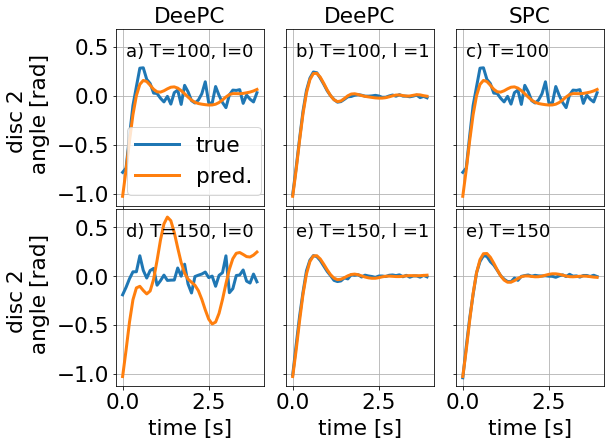

In [14]:
fig, ax = plt.subplots(2,3,figsize=(8,6),sharex=True, sharey=True)
ax[0,0].set_title('DeePC')
ax[0,1].set_title('DeePC')
ax[0,2].set_title('SPC')

t = np.arange(40)*0.1
line_1 = ax[0,0].plot(t,res_DeePC['lam_g0_T100']['y_pred'][:,1])
line_2 = ax[0,0].plot(t,res_DeePC['lam_g0_T100']['y_true'][:,1])
ax[0,0].legend(line_1+line_2,['true','pred.'])

ax[1,0].plot(t,res_DeePC['lam_g0_T150']['y_pred'][:,1])
ax[1,0].plot(t,res_DeePC['lam_g0_T150']['y_true'][:,1])

ax[0,1].plot(t,res_DeePC['lam_g1_T100']['y_pred'][:,1])
ax[0,1].plot(t,res_DeePC['lam_g1_T100']['y_true'][:,1])

ax[1,1].plot(t,res_DeePC['lam_g1_T150']['y_pred'][:,1])
ax[1,1].plot(t,res_DeePC['lam_g1_T150']['y_true'][:,1])


ax[0,2].plot(t,res_SPC['T100']['y_pred'][:,1])
ax[0,2].plot(t,res_SPC['T100']['y_true'][:,1])

ax[1,2].plot(t,res_SPC['T150']['y_pred'][:,1])
ax[1,2].plot(t,res_SPC['T150']['y_true'][:,1])

ax[0,0].set_ylabel('disc 2 \n angle [rad]')
ax[1,0].set_ylabel('disc 2 \n angle [rad]')

ax[1,0].set_xlabel('time [s]')
ax[1,1].set_xlabel('time [s]')
ax[1,2].set_xlabel('time [s]')

ax[0,0].text(0.1,0.4, 'a) T=100, l=0', horizontalalignment='left', fontsize=18)
ax[1,0].text(0.1,0.4, 'd) T=150, l=0', horizontalalignment='left', fontsize=18)

ax[0,1].text(0.1,0.4, 'b) T=100, l =1', horizontalalignment='left', fontsize=18)
ax[1,1].text(0.1,0.4, 'e) T=150, l =1', horizontalalignment='left', fontsize=18)

ax[0,2].text(0.1,0.4, 'c) T=100', horizontalalignment='left', fontsize=18)
ax[1,2].text(0.1,0.4, 'e) T=150', horizontalalignment='left', fontsize=18)

fig.tight_layout(pad=0)

Case a) and c) are identical (in their prediction):

In [15]:
print(np.linalg.norm(res_DeePC['lam_g0_T100']['y_pred']-res_SPC['T100']['y_pred']))
print(np.linalg.norm(res_DeePC['lam_g0_T100']['cost']-res_SPC['T100']['cost']))

4.2236481406016815e-12
6.263961195000882e-13


In [16]:
print('------- MPC ---------')
for name_i, res_i in res_SPC.items():
    print('{} cost: {}'.format(name_i, np.round(np.sum(res_i['cost']),3)))
    
print('------ DeePC --------')
for name_i, res_i in res_DeePC.items():
    print('{} cost: {}'.format(name_i, np.round(np.sum(res_i['cost']),3)))

------- MPC ---------
T100 cost: 6.646
T150 cost: 5.71
------ DeePC --------
lam_g0_T100 cost: 6.646
lam_g0_T150 cost: 13.771
lam_g1_T100 cost: 5.934
lam_g1_T150 cost: 5.778
